# Evaluate MPNN Performance
Review the models which have been trained and pick one for our application.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import json
import os

## Load in the Models
They are all located in a directory with a `test_summary.json` file

In [2]:
model_dirs = list(map(os.path.dirname, glob(os.path.join('networks', '**', 'test_summary.json'))))
print(f'Found {len(model_dirs)} model directories')

Found 1 model directories


In [3]:
def get_summary(path):
    """Get the summary of a run"""
    
    output = {'path': path}
    
    # Load the config
    with open(os.path.join(path, 'config.json')) as fp:
        output.update(json.load(fp))
        
    # Load in the run summary
    with open(os.path.join(path, 'test_summary.json')) as fp:
        output.update(json.load(fp))
    return output

In [4]:
models = pd.DataFrame(get_summary(p) for p in model_dirs).sort_values('mae')
models.head(5)

,atom_features,atomwise,batch_size,device,kendall_tau,mae,num_epochs,num_messages,output_layers,path,r2_score,readout_fn,rmse,spearmanr,test_time
0,128,False,32,cuda,0.756446,0.039595,64,6,3,networks/T6_b32_n64_41da3c,0.802394,sum,0.06048,0.921726,0.212974


## Validate the Model
Visualize the results on the hold-out set of 10% of our data

In [5]:
best_model = models.iloc[0]

In [6]:
best_model

atom_features                           128
atomwise                              False
batch_size                               32
device                                 cuda
kendall_tau                        0.756446
mae                               0.0395946
num_epochs                               64
num_messages                              6
output_layers                             3
path             networks/T6_b32_n64_41da3c
r2_score                           0.802394
readout_fn                              sum
rmse                              0.0604797
spearmanr                          0.921726
test_time                          0.212974
Name: 0, dtype: object

In [7]:
test_data = pd.read_csv(os.path.join(best_model['path'], 'test_results.csv'))

In [9]:
test_data = pd.read_csv(os.path.join(best_model['path'], 'test_results.csv'))
original_molecule_info = pd.read_csv('../data/input/GDB9/test.csv')
test_data = pd.concat([test_data, original_molecule_info[['filename', 'n_heavy_atoms','smiles_0', 'xyz', 'xyz_oxidized']]], axis=1)


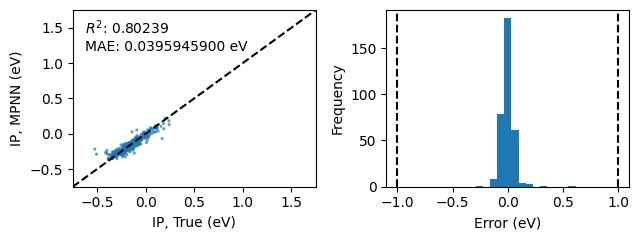

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))

errors = (test_data['pred'] - test_data['true'])

ax = axs[0]
ax.scatter(test_data['true'], test_data['pred'], s=5, alpha=0.7, edgecolor='none')
ax.text(0.050, 0.950, f'$R^2$:{best_model["r2_score"]: .5f}\nMAE:{errors.abs().mean(): .10f} eV', 
       transform=ax.transAxes, va='top', ha='left')

ax.set_xlim([-0.75, 1.75])
ax.set_ylim([-0.75, 1.75])

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('IP, True (eV)')
ax.set_ylabel('IP, MPNN (eV)')

ax = axs[1]


ax.hist(errors, bins=np.linspace(-1, 1, 32))
ax.text(1, 0.950, f'', 
       transform=ax.transAxes, va='top', ha='right')

ax.set_ylim(ax.get_ylim())
ax.plot([-1, -1], ax.get_ylim(), 'k--')
ax.plot([1, 1], ax.get_ylim(), 'k--')

ax.set_xlabel('Error (eV)')
ax.set_ylabel('Frequency')
fig.tight_layout()
plt.savefig("schnetDelta.png")

Link the best model to the local directory

In [11]:
if os.path.exists('best_model'):
    os.unlink('best_model')
os.symlink(os.path.join(best_model['path'], 'best_model'), 'best_model')

In [12]:
if os.path.exists('best_config.json'):
    os.unlink('best_config.json')
os.symlink(os.path.join(best_model['path'], 'config.json'), 'best_config.json')

In [13]:
if os.path.exists('best_performance.json'):
    os.unlink('best_performance.json')
os.symlink(os.path.join(best_model['path'], 'test_summary.json'), 'best_performance.json')

In [14]:
test_data.to_csv('wB97XDA_ionization_potential.csv', index=False)